In [10]:
import torch
import torch.nn as nn
import math
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.functional import relu
import matplotlib.pyplot as plt
%matplotlib inline
data_dir='/home/ymh/GW_data_max1e-21_noise5e-22/'
device=torch.device('cuda:0')

pi=3.1415926
G=6.673e-11
c=299792458.0

Mpc=3.08567758e22
Msun = 1.989e30

In [11]:
def get_params(batch_size,step):
    
    
    params_dir='injection_bns_%s.txt'%(step*batch_size+1)
    params=np.loadtxt(data_dir+params_dir)
    params=params.reshape(1,9)
    
    i=1
    while i<batch_size:
        params_dir_append='injection_bns_%s.txt'%(step*batch_size+i+1)
        params_append=np.loadtxt(data_dir+params_dir_append)
        params_append=params_append.reshape(1,9)
        params=np.concatenate((params,params_append),axis=0)
        i=i+1
        
    return params

In [12]:
def zoom_func(params,start_t,end_t,wave_length,noise_factor):
    det_num=3
    noise_scale=5.0e-22
    #params=Variable(torch.from_numpy(params).cuda())
    #params=torch.tensor([params],requires_grad=True,dtype=torch.double).to(device)
    inj_time=torch.tensor(params[0],dtype=torch.double,device=device)
    Mc=torch.tensor(params[1]*Msun,dtype=torch.double,device=device)
    sphi=params[3]
    stheta=params[4]
    spsi=params[5]
    dl0=torch.tensor(params[6],dtype=torch.double,device=device)
    cosi=torch.tensor(params[7],dtype=torch.double,device=device)


    T1=end_t[0]-start_t[0]
    T2=end_t[1]-start_t[1]
    T3=end_t[2]-start_t[2]
    fs1=wave_length/T1
    fs2=wave_length/T2
    fs3=wave_length/T3
    nsamples=wave_length
    t1=start_t[0]+np.arange(nsamples)/fs1
    t2=start_t[1]+np.arange(nsamples)/fs2
    t3=start_t[2]+np.arange(nsamples)/fs3

    Det1_V=np.array([-2.161414928e+06,-3.834695183e+06,4.600350224e+06])
    Det2_V=np.array([-7.427604192e+04,-5.496283721e+06,3.224257016e+06])
    Det3_V=np.array([4546374.0,842990.0,4378577.0])
    Det1_d=np.array([[-0.392614701790361,-0.077612252813702,-0.247388405118613],
                     [-0.077612252813702,0.319524089053145,0.227998293910978],
                     [-0.247388405118613,0.227998293910978,0.073090613199948]])
    Det2_d=np.array([[0.411281743683125,0.140209630402064,0.247293475274344],
                     [0.140209630402064,-0.109005942619247,-0.181616030843724],
                     [0.247293475274344,-0.181616030843724,-0.302275800865383]])
    Det3_d=np.array([[0.243874678248284,-0.099086615422263,-0.232575796255783],
                     [-0.099086615422263,-0.447827871578090,0.187828534783639],
                     [-0.232575796255783,0.187828534783639,0.203953193329806]])
    
    
    
    dl=dl0*Mpc

    m1=math.sin(sphi)*math.cos(spsi)-math.cos(sphi)*math.cos(stheta)*math.sin(spsi)
    m2=-math.cos(sphi)*math.cos(spsi)-math.sin(sphi)*math.cos(stheta)*math.sin(spsi)
    m3=math.sin(stheta)*math.sin(spsi)
    n1=-math.sin(sphi)*math.sin(spsi)-math.cos(sphi)*math.cos(stheta)*math.cos(spsi)
    n2=math.cos(sphi)*math.sin(spsi)-math.sin(sphi)*math.cos(stheta)*math.cos(spsi)
    n3 =math.sin(stheta)*math.cos(spsi)
    mm=torch.tensor([m1*m1,m1*m2,m1*m3,m2*m1,m2*m2,m2*m3,m3*m1,m3*m2,m3*m3],dtype=torch.double,device=device)
    mn=torch.tensor([m1*n1,m1*n2,m1*n3,m2*n1,m2*n2,m2*n3,m3*n1,m3*n2,m3*n3],dtype=torch.double,device=device)
    nm=torch.tensor([n1*m1,n1*m2,n1*m3,n2*m1,n2*m2,n2*m3,n3*m1,n3*m2,n3*m3],dtype=torch.double,device=device)
    nn=torch.tensor([n1*n1,n1*n2,n1*n3,n2*n1,n2*n2,n2*n3,n3*n1,n3*n2,n3*n3],dtype=torch.double,device=device)
    e_plus=mm-nn
    e_cross=mn+nm
    #d1=torch.from_numpy(Det1_d.reshape(9)).cuda()
    #d2=torch.from_numpy(Det2_d.reshape(9)).cuda()
    #d3=torch.from_numpy(Det3_d.reshape(9)).cuda()
    d1=torch.tensor(Det1_d.reshape(9),dtype=torch.double,device=device)
    d2=torch.tensor(Det2_d.reshape(9),dtype=torch.double,device=device)
    d3=torch.tensor(Det3_d.reshape(9),dtype=torch.double,device=device)
    #Fp1=torch.sum(e_plus*Variable(d1))
    #Fx1=torch.sum(e_cross*Variable(d1))
    #Fp2=torch.sum(e_plus*Variable(d2))
    #Fx2=torch.sum(e_cross*Variable(d2))
    #Fp3=torch.sum(e_plus*Variable(d3))
    #Fp3=torch.sum(e_cross*Variable(d3))
    Fp1=torch.sum(e_plus*d1)
    Fx1=torch.sum(e_cross*d1)
    Fp2=torch.sum(e_plus*d2)
    Fx2=torch.sum(e_cross*d2)
    Fp3=torch.sum(e_plus*d3)
    Fx3=torch.sum(e_cross*d3)
    
    omega = torch.tensor([math.sin(stheta)*math.cos(sphi),math.sin(stheta)*math.sin(sphi),math.cos(stheta)],
                         dtype=torch.double,device=device)

    #delay_1=-torch.sum(Variable(torch.from_numpy(Det1_V).cuda())*omega)/c
    #delay_2=-torch.sum(Variable(torch.from_numpy(Det2_V).cuda())*omega)/c
    #delay_3=-torch.sum(Variable(torch.from_numpy(Det3_V).cuda())*omega)/c
    delay_1=-torch.sum(torch.from_numpy(Det1_V).to(device)*omega)/c
    delay_2=-torch.sum(torch.from_numpy(Det2_V).to(device)*omega)/c
    delay_3=-torch.sum(torch.from_numpy(Det3_V).to(device)*omega)/c
    tc1=inj_time+delay_1
    tc2=inj_time+delay_2
    tc3=inj_time+delay_3
    idinjt1=torch.ceil((tc1-start_t[0])*fs1)
    idinjt2=torch.ceil((tc2-start_t[1])*fs2)
    idinjt3=torch.ceil((tc3-start_t[2])*fs3)
    
    tau1=tc1-torch.from_numpy(t1).to(device)
    tau2=tc2-torch.from_numpy(t2).to(device)
    tau3=tc3-torch.from_numpy(t3).to(device)
    
    tau1_l=torch.from_numpy(end_t[0]-t1).to(device)
    tau2_l=torch.from_numpy(end_t[1]-t2).to(device)
    tau3_l=torch.from_numpy(end_t[2]-t3).to(device)
    
    
    tau1_phi=torch.pow(relu(tau1),5.0/8)
    phi_t1=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau1_phi
    tau1_Ah=torch.pow(relu(5/(c*tau1)),1.0/4)
    Ah1=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau1_Ah
    hp1=0.5*(1+torch.pow(cosi,2.0))*(Ah1*torch.cos(phi_t1))
    hx1=Ah1*torch.cos(phi_t1)*cosi
    
    tau1_phi_l=torch.pow(relu(tau1_l),5.0/8)
    phi_t1_l=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau1_phi_l
    tau1_Ah_l=torch.pow(relu(5/(c*tau1_l)),1.0/4)
    Ah1_l=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau1_Ah_l
    hp1_l=0.5*(1+torch.pow(cosi,2.0))*(Ah1_l*torch.cos(phi_t1_l))
    hx1_l=Ah1_l*torch.cos(phi_t1_l)*cosi
    

    tau2_phi=torch.pow(relu(tau2),5.0/8)
    phi_t2=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau2_phi
    tau2_Ah=torch.pow(relu(5/(c*tau2)),1.0/4)
    Ah2=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau2_Ah
    hp2=0.5*(1+torch.pow(cosi,2.0))*(Ah2*torch.cos(phi_t2))
    hx2=Ah2*torch.cos(phi_t2)*cosi
    
    tau2_phi_l=torch.pow(relu(tau2_l),5.0/8)
    phi_t2_l=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau2_phi_l
    tau2_Ah_l=torch.pow(relu(5/(c*tau2_l)),1.0/4)
    Ah2_l=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau2_Ah_l
    hp2_l=0.5*(1+torch.pow(cosi,2.0))*(Ah2_l*torch.cos(phi_t2_l))
    hx2_l=Ah2_l*torch.cos(phi_t2_l)*cosi

    
    tau3_phi=torch.pow(relu(tau3),5.0/8)
    phi_t3=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau3_phi
    tau3_Ah=torch.pow(relu(5/(c*tau3)),1.0/4)
    Ah3=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau3_Ah
    hp3=0.5*(1+torch.pow(cosi,2.0))*(Ah3*torch.cos(phi_t3))
    hx3=Ah3*torch.cos(phi_t3)*cosi
    
    tau3_phi_l=torch.pow(relu(tau3_l),5.0/8)
    phi_t3_l=-2*torch.pow((5*G*Mc/(c*c*c)),-5.0/8)*tau3_phi_l
    tau3_Ah_l=torch.pow(relu(5/(c*tau3_l)),1.0/4)
    Ah3_l=(1/dl)*torch.pow(G*Mc/(c*c),5.0/4)*tau3_Ah_l
    hp3_l=0.5*(1+torch.pow(cosi,2.0))*(Ah3_l*torch.cos(phi_t3_l))
    hx3_l=Ah3_l*torch.cos(phi_t3_l)*cosi
    
    new_scale=1.0e-22
    
    wnoise1=noise_scale*torch.from_numpy(np.random.randn(wave_length)).to(device)
    wnoise2=noise_scale*torch.from_numpy(np.random.randn(wave_length)).to(device)
    wnoise3=noise_scale*torch.from_numpy(np.random.randn(wave_length)).to(device)
    Wave1=(Fp1*hp1+Fx1*hx1)
    Wave2=(Fp2*hp2+Fx2*hx2)
    Wave3=(Fp3*hp3+Fx3*hx3)

    wave1_l=(Fp1*hp1_l+Fx1*hx1_l).view(1,1,wave_length,1)
    wave2_l=(Fp2*hp2_l+Fx2*hx2_l).view(1,1,wave_length,1)
    wave3_l=(Fp3*hp3_l+Fx3*hx3_l).view(1,1,wave_length,1)
    energy1=torch.pow(wave1_l,2).mean().sqrt()
    energy2=torch.pow(wave2_l,2).mean().sqrt()
    energy3=torch.pow(wave3_l,2).mean().sqrt()
    
    wave1_c=Wave1*(new_scale/energy1)
    wave2_c=Wave2*(new_scale/energy2)
    wave3_c=Wave3*(new_scale/energy3)

    Wave1_n=wave1_c+wnoise1*noise_factor
    Wave2_n=wave2_c+wnoise2*noise_factor
    Wave3_n=wave3_c+wnoise3*noise_factor
    Wave1_n=Wave1_n.view(1,1,wave_length,1)
    Wave2_n=Wave2_n.view(1,1,wave_length,1)
    Wave3_n=Wave3_n.view(1,1,wave_length,1)
    #Ah1=Ah1.view(1,1,wave_length,1)
    #Ah2=Ah2.view(1,1,wave_length,1)
    #Ah3=Ah3.view(1,1,wave_length,1)
    Ah1=wave1_c.view(1,1,wave_length,1)
    Ah2=wave2_c.view(1,1,wave_length,1)
    Ah3=wave3_c.view(1,1,wave_length,1)
    Ahtot=torch.cat((Ah1,Ah2,Ah3),0)
    Wave=torch.cat((Wave1_n,Wave2_n,Wave3_n),0)
    Wave_l=torch.cat((wave1_l,wave2_l,wave3_l),0)
    tc=torch.tensor([tc1,tc2,tc3],device=device)
    
    return Wave*2.0e21,Ahtot*2.0e21,tc

In [13]:
def get_batch(batch_size,step,noise_factor,train_id):
    resolution=[16384,2048,1024,512,256,128,64,32,16]
    params=get_params(batch_size,step)
    waves=[[],[],[],[],[],[],[],[],[]]
    ahtots=[[],[],[],[],[],[],[],[],[]]
    inj_times=[]
    start_t=np.zeros((batch_size,3))+0.0
    end_t=np.zeros((batch_size,3))+1.0
    for i in range(batch_size):
        wave,ahtot,tc=zoom_func(params[i],start_t[i,:],end_t[i,:],resolution[0],noise_factor)
        waves[0].append(wave)
        ahtots[0].append(ahtot)
        inj_times.append(tc)
    waves[0]=torch.cat(waves[0],0)
    ahtots[0]=torch.cat(ahtots[0],0)
    inj_times=torch.cat(inj_times,0)
    
    for k in range(1,9):
        if train_id==k:
            start_t=inj_times.data.cpu().numpy()-np.ones(batch_size*3)*(0.5**(k-1))*6.5/64-(0.5**(k-1))*1.0/64
        else:
            start_t=inj_times.data.cpu().numpy()-np.random.rand(batch_size*3)*(0.5**(k-1))*6.0/64-(0.5**(k-1))*1.0/64
        start_p=np.int32(np.around(start_t*resolution[0]))
        for i in range(3*batch_size):
            wave1=waves[0][i,:,start_p[i]:(start_p[i]+resolution[k]),:].view(1,1,resolution[k],1)
            ahtot1=ahtots[0][i,:,start_p[i]:(start_p[i]+resolution[k]),:].view(1,1,resolution[k],1)
            waves[k].append(wave1)
            ahtots[k].append(ahtot1)
        waves[k]=torch.cat(waves[k],0)
        ahtots[k]=torch.cat(ahtots[k],0)
        

    return waves,ahtots,inj_times


In [14]:
'''
    start_t=inj_times.data.cpu().numpy()-np.random.rand(batch_size*3)*6.0/64-1.0/64
    #start_t=inj_times.data.cpu().numpy()-np.ones(batch_size*3)*7.4/64-0.5/64
    end_t=start_t+8.0/64
    start_t=start_t.reshape(-1,3)
    end_t=end_t.reshape(-1,3)
    for i in range(batch_size):
        wave,ahtot,tc=zoom_func(params[i],start_t[i,:],end_t[i,:],2048,noise_factor)
        waves[1].append(wave)
        ahtots[1].append(ahtot)
        #inj_times.append(tc)
    waves[1]=torch.cat(waves[1],0)
    ahtots[1]=torch.cat(ahtots[1],0)
    
    #start_t=inj_times.data.cpu().numpy()-np.random.rand(batch_size*3)*4.0*5.0/(32*64)-0.5*5.0/(32*64)
    start_t=inj_times.data.cpu().numpy()-np.ones(batch_size*3)*7.4*8.0/(64*64)-0.5*8.0/(64*64)
    end_t=start_t+8.0*8.0/(64*64)
    start_t=start_t.reshape(-1,3)
    end_t=end_t.reshape(-1,3)
    for i in range(batch_size):
        wave,ahtot,tc=zoom_func(params[i],start_t[i,:],end_t[i,:],256,noise_factor)
        waves[2].append(wave)
        ahtots[2].append(ahtot)
        #inj_times.append(tc)
    waves[2]=torch.cat(waves[2],0)
    ahtots[2]=torch.cat(ahtots[2],0)
'''

'\n    start_t=inj_times.data.cpu().numpy()-np.random.rand(batch_size*3)*6.0/64-1.0/64\n    #start_t=inj_times.data.cpu().numpy()-np.ones(batch_size*3)*7.4/64-0.5/64\n    end_t=start_t+8.0/64\n    start_t=start_t.reshape(-1,3)\n    end_t=end_t.reshape(-1,3)\n    for i in range(batch_size):\n        wave,ahtot,tc=zoom_func(params[i],start_t[i,:],end_t[i,:],2048,noise_factor)\n        waves[1].append(wave)\n        ahtots[1].append(ahtot)\n        #inj_times.append(tc)\n    waves[1]=torch.cat(waves[1],0)\n    ahtots[1]=torch.cat(ahtots[1],0)\n    \n    #start_t=inj_times.data.cpu().numpy()-np.random.rand(batch_size*3)*4.0*5.0/(32*64)-0.5*5.0/(32*64)\n    start_t=inj_times.data.cpu().numpy()-np.ones(batch_size*3)*7.4*8.0/(64*64)-0.5*8.0/(64*64)\n    end_t=start_t+8.0*8.0/(64*64)\n    start_t=start_t.reshape(-1,3)\n    end_t=end_t.reshape(-1,3)\n    for i in range(batch_size):\n        wave,ahtot,tc=zoom_func(params[i],start_t[i,:],end_t[i,:],256,noise_factor)\n        waves[2].append(wave

In [15]:
class Net_class_2048(nn.Module):
    def __init__(self):
        super(Net_class_2048,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((4,1),(4,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(64*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,64*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_2048=Net_class_2048().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
net_2048.to(device)

Net_class_2048(
  (conv1): Conv2d(1, 16, kernel_size=(17, 1), stride=(1, 1), padding=(8, 0), bias=False)
  (pool1): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (pool2): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Soft

In [16]:
class Net_class_1024(nn.Module):
    def __init__(self):
        super(Net_class_1024,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((4,1),(4,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(32*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,32*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_1024=Net_class_1024().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
net_1024.to(device)

Net_class_1024(
  (conv1): Conv2d(1, 16, kernel_size=(17, 1), stride=(1, 1), padding=(8, 0), bias=False)
  (pool1): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (pool2): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Soft

In [17]:
class Net_class_512(nn.Module):
    def __init__(self):
        super(Net_class_512,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((4,1),(4,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(16*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,16*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_512=Net_class_512().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
net_512.to(device)

Net_class_512(
  (conv1): Conv2d(1, 16, kernel_size=(17, 1), stride=(1, 1), padding=(8, 0), bias=False)
  (pool1): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (pool2): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softm

In [18]:
class Net_class_256(nn.Module):
    def __init__(self):
        super(Net_class_256,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((2,1),(2,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(16*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,16*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_256=Net_class_256().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
net_256.to(device)

Net_class_256(
  (conv1): Conv2d(1, 16, kernel_size=(17, 1), stride=(1, 1), padding=(8, 0), bias=False)
  (pool1): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softm

In [19]:
class Net_class_128(nn.Module):
    def __init__(self):
        super(Net_class_128,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((2,1),(2,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(8*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,8*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_128=Net_class_128().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
net_128.to(device)

Net_class_128(
  (conv1): Conv2d(1, 16, kernel_size=(17, 1), stride=(1, 1), padding=(8, 0), bias=False)
  (pool1): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softma

In [20]:
class Net_class_64(nn.Module):
    def __init__(self):
        super(Net_class_64,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((2,1),(2,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(4*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,4*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_64=Net_class_64().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
net_64.to(device)

Net_class_64(
  (conv1): Conv2d(1, 16, kernel_size=(17, 1), stride=(1, 1), padding=(8, 0), bias=False)
  (pool1): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax

In [21]:
class Net_class_32(nn.Module):
    def __init__(self):
        super(Net_class_32,self).__init__()
        self.conv1=nn.Conv2d(1,16,(17,1),stride=(1,1),padding=(8,0),bias=False)
        self.pool1=nn.MaxPool2d((4,1),(4,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(9,1),stride=(1,1),padding=(4,0),bias=False)
        self.pool2=nn.MaxPool2d((2,1),(2,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool3=nn.MaxPool2d((2,1),(2,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(7,1),stride=(1,1),padding=(3,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(2*64,64)
        self.fc2=nn.Linear(64,2)
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,2*64)))
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_32=Net_class_32().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
net_32.to(device)

Net_class_32(
  (conv1): Conv2d(1, 16, kernel_size=(17, 1), stride=(1, 1), padding=(8, 0), bias=False)
  (pool1): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0), bias=False)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
  (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax

In [28]:
class Net_class_16(nn.Module):
    def __init__(self):
        super(Net_class_16,self).__init__()
        self.conv1=nn.Conv2d(1,16,(11,1),stride=(1,1),padding=(5,0),bias=False)
        self.pool1=nn.MaxPool2d((2,1),(2,1))
        self.bn1=nn.BatchNorm2d(16)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(16,32,(7,1),stride=(1,1),padding=(3,0),bias=False)
        self.pool2=nn.MaxPool2d((1,1),(1,1))
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,(5,1),stride=(1,1),padding=(2,0),bias=False)
        self.pool3=nn.MaxPool2d((1,1),(1,1))
        self.bn3=nn.BatchNorm2d(64)
        #self.conv4=nn.Conv2d(64,128,(5,1),stride=(1,1),padding=(2,0),bias=False)
        #self.pool4=nn.MaxPool2d((2,1),(2,1))
        #self.bn4=nn.BatchNorm2d(128)
        self.fc1=nn.Linear(8*64,128)
        self.fc2=nn.Linear(128,2)
        
        #self.conv5=nn.Conv2d(256,1,(1,1),stride=(1,1),bias=False)
        self.softmax=nn.Softmax()
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(self.pool1(self.bn1(x)))

        x=self.conv2(x)
        x=self.relu(self.pool2(self.bn2(x)))

        x=self.conv3(x)
        x=self.relu(self.pool3(self.bn3(x)))

        #x=self.conv4(x)
        #x=self.relu(self.pool4(self.bn4(x)))

        x=self.relu(self.fc1(x.view(-1,8*64)))
    
        x=self.fc2(x)
        #x=self.conv5(x)
        x=self.softmax(x)
        return x
    
net_16=Net_class_16().double()
#net_zoom0=torch.load('/home/yinminghao/GW_nets/net0_zoom0_max1e-21_noise5e-22.pkl')
net_16.to(device)

Net_class_16(
  (conv1): Conv2d(1, 16, kernel_size=(11, 1), stride=(1, 1), padding=(5, 0), bias=False)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(16, 32, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
  (pool2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0), bias=False)
  (pool3): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softm

In [29]:
optimizer=torch.optim.Adam(net_16.parameters(),lr=0.0001)

In [38]:
Nreal=2000
batch_size=50
det_num=3
noise_factor=1.1
for step in range(int(Nreal/batch_size)):
    optimizer.zero_grad()
    waves,waves_c,tc=get_batch(batch_size,step,noise_factor,train_id=8)
    
    #waves_c,ahtots_c,tc_c=get_batch(batch_size,step,0)
    
    att=torch.tensor(np.random.randint(0,2,batch_size*3),dtype=torch.double,device=device).view(batch_size*3,1,1,1)
    Wave=waves[8]-att*waves_c[8]
    out=net_16(Wave)
    
    att_np=att.squeeze().data.cpu().numpy()
    target=torch.ones(3*batch_size,2).double().to(device)
    for i in range(3*batch_size):
        target[i,int(att_np[i])]=0
    loss=-torch.mean(torch.log(out)*target)
    loss.backward()
    optimizer.step()
    
    pred=out.max(1)[1]
    count=0
    for j in range(3*batch_size):
        if pred[j].data.cpu().numpy()==int(att.squeeze()[j].data.cpu().numpy()):
            count=count+1
    print(loss.data.cpu().numpy(),count)
    
    
    

/home/ymh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.10202516788151936 14
0.09293259805542978 9
0.1159397383663283 15
0.1274058010066216 16
0.08380779529620104 11
0.08812561449877322 10
0.06839008043037847 7
0.10624756259371679 11
0.09113038462686289 16
0.12036485318387896 14
0.09718432510027449 12
0.11501909423442286 16
0.10202084262659912 14
0.07747306513949459 7
0.10916715497711588 15
0.13040309808508296 16
0.07371717936903285 11
0.11100144853086368 10
0.1044444667538194 13
0.1735704489336346 20
0.12576504720198434 16
0.1300653934221227 14
0.12875617802173214 16
0.15440308815248505 20
0.07862059660819565 8
0.0949613203710274 12
0.11103829404732773 15
0.13945707685152733 17
0.11254363608732922 12
0.1266666067820348 13
0.11574459584029921 15
0.10869228737392991 18
0.11002571859913678 11
0.06443496362329909 6
0.11332229031423426 18
0.10223243686869962 12
0.09992669170913142 11
0.09284744572414444 11
0.09876912344455493 13
0.12581297958571186 18


/home/intelligent/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


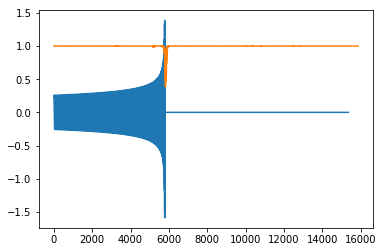

In [72]:
waves,waves_c,tc=get_batch(2,15,noise_factor=1.0,train_id=10)
net1=net_512.eval()
history=torch.zeros(15872,6,2).to(device)
with torch.no_grad():
    for i in range(15872):
        out_cut=net1(waves[0][:,:,i:i+512,:])
        history[i,:,:]=out_cut.squeeze()
plt.plot(waves_c[0][1].squeeze().data.cpu().numpy()[512:15872])
plt.plot(history[:,1,0].cpu().data.numpy())

In [39]:
torch.save(net_16.state_dict(),'/home/ymh/GW_nets/net_class_16.pkl')

In [21]:
optimizer=torch.optim.Adam(net_class1.parameters(),lr=0.0001)

In [55]:
Nreal=2000
batch_size=50
det_num=3
noise_factor=0.9
for step in range(int(Nreal/batch_size)):
    optimizer.zero_grad()
    waves,waves_c,tc=get_batch(batch_size,step,noise_factor)
    
    #waves_c,ahtots_c,tc_c=get_batch(batch_size,step,0)
    
    att1=torch.tensor(np.random.randint(0,2,batch_size*3),dtype=torch.double,device=device).view(batch_size*3,1,1,1)
    Wave1=waves[1]-att1*waves_c[1]
    out1=net_class1(Wave1)
    
    att1_np=att1.squeeze().data.cpu().numpy()
    target=torch.ones(3*batch_size,2).double().to(device)
    for i in range(3*batch_size):
        target[i,int(att1_np[i])]=0
    loss1=-torch.mean(torch.log(out1)*target)
    loss1.backward()
    optimizer.step()
    
    pred=out1.max(1)[1]
    count=0
    for j in range(3*batch_size):
        if pred[j].data.cpu().numpy()==int(att1.squeeze()[j].data.cpu().numpy()):
            count=count+1
    print(loss1.data.cpu().numpy(),count)
    
    

/home/intelligent/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.07791686790558064 10
0.04537303439395947 3
0.04206712028199268 4
0.06571546653563905 6
0.06166887539248238 6
0.05887158728962164 6
0.04420175701282045 2
0.05294864600290575 3
0.0749550640121506 10
0.05611224936593351 4
0.07041452019036844 10
0.05702170987961564 3
0.05390257644601568 5
0.051794805508344297 3
0.05004572466968654 4
0.05932449999334759 6
0.09982154205524595 10
0.06371513160598534 5
0.04791848986962646 5
0.07531513396312044 9
0.0891047816580031 11
0.09458146033834924 13
0.041863441942233015 2
0.06662488847843584 5
0.047880381001129776 3
0.05043457378875759 4
0.06994794546532541 13
0.04715210115938774 7
0.06667386606486199 6
0.07574358620216441 12
0.07348338585557831 11
0.04779448173496461 4
0.05942332801554437 5
0.05736891988462587 7
0.041067023336335766 3
0.051873695014966435 5
0.04523141946730285 4
0.0371960007254177 3
0.04756708173906692 6
0.06406660947812244 7


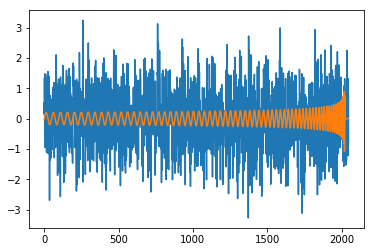

In [28]:
plt.plot(waves[1][1].squeeze().data.cpu().numpy())
plt.plot(waves_c[1][1].squeeze().data.cpu().numpy())

In [194]:
waves,waves_c,tc=get_batch(2,15,noise_factor)
net1=net_class1.eval()

TypeError: get_batch() missing 1 required positional argument: 'train_id'

In [57]:
history=torch.zeros(14336,6,2).to(device)
with torch.no_grad():
    for i in range(14336):
        out_cut=net1(waves[0][:,:,i:i+2048,:])
        history[i,:,:]=out_cut.squeeze()
   

/home/intelligent/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


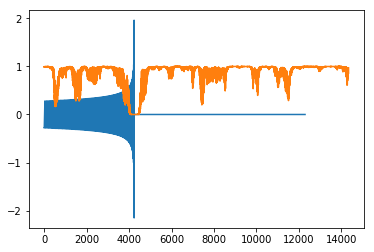

In [63]:
plt.plot(waves_c[0][0].squeeze().data.cpu().numpy()[2048:14336])
plt.plot(history[:,0,0].cpu().data.numpy())

In [41]:
waves_c[0].size()

torch.Size([6, 1, 16384, 1])

In [57]:
optimizer=torch.optim.Adam(net_class2.parameters(),lr=0.0001)

In [88]:
Nreal=2000
batch_size=50
det_num=3
noise_factor=1.4
for step in range(int(Nreal/batch_size)):
    optimizer.zero_grad()
    waves,waves_c,tc=get_batch(batch_size,step,noise_factor)
    
    #waves_c,ahtots_c,tc_c=get_batch(batch_size,step,0)
    
    att2=torch.tensor(np.random.randint(0,2,batch_size*3),dtype=torch.double,device=device).view(batch_size*3,1,1,1)
    Wave2=waves[2]-att2*waves_c[2]
    out2=net_class2(Wave2)
    
    att2_np=att2.squeeze().data.cpu().numpy()
    target=torch.ones(3*batch_size,2).double().to(device)
    for i in range(3*batch_size):
        target[i,int(att2_np[i])]=0
    loss2=-torch.mean(torch.log(out2)*target)
    loss2.backward()
    optimizer.step()
    
    pred=out2.max(1)[1]
    count=0
    for j in range(3*batch_size):
        if pred[j].data.cpu().numpy()==int(att2.squeeze()[j].data.cpu().numpy()):
            count=count+1
    print(loss2.data.cpu().numpy(),count)

/home/intelligent/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.04672642003541415 4
0.08973637074005965 10
0.11877170241321129 15
0.14370198177945764 20
0.10730751435287933 13
0.07489794557204622 7
0.10783853667224648 16
0.09995166476975735 12
0.10880011602753702 11
0.14905389218559142 17
0.0546141375324558 4
0.11316820798139192 19
0.07727095374653893 9
0.15143910074299513 19
0.09928987738814474 12
0.14749610487410914 16
0.10442340523134096 11
0.11642932099875739 14
0.0829542862215424 9
0.07643576446400215 12
0.10847971170823074 10
0.11305235621172609 13
0.095008819768189 10
0.12027275516910142 13
0.06259969897527952 11
0.1280432090102885 20
0.10805603166507863 13
0.12664880076025822 18
0.0913654931753885 13
0.10363713453309122 14
0.10960413747610107 12
0.054086763116638396 7
0.13828385898734305 21
0.15207235026539948 21
0.15404757594645066 16
0.09617374727208598 13
0.10028152619467273 14
0.12610048781133604 12
0.11804233631395711 18
0.0749061801676644 6


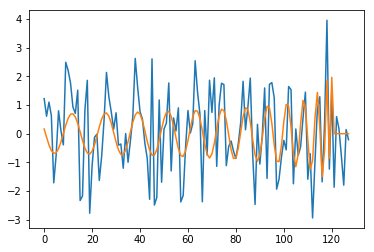

In [25]:
waves,waves_c,tc=get_batch(2,15,noise_factor=1.2,train_id=5)
#net2=net_class2.eval()
plt.plot(waves[5][3].squeeze().data.cpu().numpy())
plt.plot(waves_c[5][3].squeeze().data.cpu().numpy())

In [95]:
history=torch.zeros(1792,6,2).to(device)
with torch.no_grad():
    for i in range(1792):
        out_cut=net2(waves[1][:,:,i:i+256,:])
        history[i,:,:]=out_cut.squeeze()

/home/intelligent/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


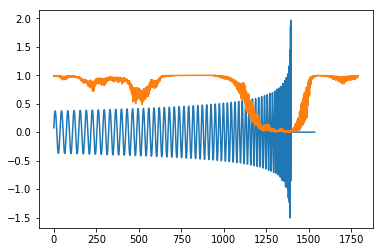

In [96]:
plt.plot(waves_c[1][3].squeeze().data.cpu().numpy()[256:1792])
plt.plot(history[:,3,0].cpu().data.numpy())

In [30]:
np.int32(np.around([0.37,1.64]))

array([0, 2], dtype=int32)

In [117]:
optimizer=torch.optim.Adam(net_class2_128.parameters(),lr=0.0001)

In [124]:
Nreal=2000
batch_size=50
det_num=3
noise_factor=1.2
for step in range(int(Nreal/batch_size)):
    optimizer.zero_grad()
    waves,waves_c,tc=get_batch(batch_size,step,noise_factor)
    
    #waves_c,ahtots_c,tc_c=get_batch(batch_size,step,0)
    
    att2=torch.tensor(np.random.randint(0,2,batch_size*3),dtype=torch.double,device=device).view(batch_size*3,1,1,1)
    Wave2=waves[2]-att2*waves_c[2]
    out2=net_class2_128(Wave2)
    
    att2_np=att2.squeeze().data.cpu().numpy()
    target=torch.ones(3*batch_size,2).double().to(device)
    for i in range(3*batch_size):
        target[i,int(att2_np[i])]=0
    loss2=-torch.mean(torch.log(out2)*target)
    loss2.backward()
    optimizer.step()
    
    pred=out2.max(1)[1]
    count=0
    for j in range(3*batch_size):
        if pred[j].data.cpu().numpy()==int(att2.squeeze()[j].data.cpu().numpy()):
            count=count+1
    print(loss2.data.cpu().numpy(),count)

/home/intelligent/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.05934197620368297 4
0.0784891721088084 7
0.08718250729891736 11
0.06340077973868552 5
0.06985661875736202 7
0.054336683971119515 4
0.051252205273363036 6
0.0845960844020053 7
0.05116517076822049 5
0.05619673064432895 8
0.04979668658863219 7
0.07523614371709336 8
0.04901289977630625 6
0.04825282017601071 6
0.06908366749191187 10
0.08236687578480555 9
0.07551684327305803 10
0.06283972357181712 8
0.08538303061593758 7
0.05032594078505134 5
0.06151360267986513 6
0.046981547808425124 4
0.045894706786115735 5
0.0737738131112912 9
0.06088160127574813 7
0.046778538335155516 4
0.05017915244218441 4
0.0660630364262473 10
0.06144020509229303 6
0.034833386358419795 2
0.06352855584265259 8
0.05051653051041776 5
0.05205863533945808 7
0.04950384653044606 5
0.04873881454464858 5
0.06953050352970871 6
0.0665274126266195 8
0.08002875294978448 11
0.05124787240261125 5
0.07624738034189517 9


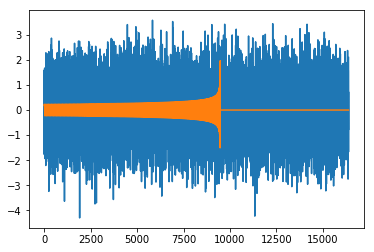

In [139]:
waves,waves_c,tc=get_batch(2,15,noise_factor=1.0)
net2=net_class2_128.eval()
plt.plot(waves[0][3].squeeze().data.cpu().numpy())
plt.plot(waves_c[0][3].squeeze().data.cpu().numpy())

In [140]:
history=torch.zeros(1920,6,2).to(device)
with torch.no_grad():
    for i in range(1920):
        out_cut=net2(waves[1][:,:,i:i+128,:])
        history[i,:,:]=out_cut.squeeze()

/home/intelligent/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


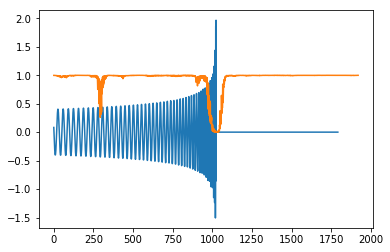

In [141]:
plt.plot(waves_c[1][3].squeeze().data.cpu().numpy()[128:1920])
plt.plot(history[:,3,0].cpu().data.numpy())

In [144]:
optimizer=torch.optim.Adam(net_class2_64.parameters(),lr=0.0001)

In [ ]:
Nreal=2000
batch_size=50
det_num=3
noise_factor=1.0
for step in range(int(Nreal/batch_size)):
    optimizer.zero_grad()
    waves,waves_c,tc=get_batch(batch_size,step,noise_factor)
    
    #waves_c,ahtots_c,tc_c=get_batch(batch_size,step,0)
    
    att2=torch.tensor(np.random.randint(0,2,batch_size*3),dtype=torch.double,device=device).view(batch_size*3,1,1,1)
    Wave2=waves[2]-att2*waves_c[2]
    out2=net_class2_64(Wave2)
    
    att2_np=att2.squeeze().data.cpu().numpy()
    target=torch.ones(3*batch_size,2).double().to(device)
    for i in range(3*batch_size):
        target[i,int(att2_np[i])]=0
    loss2=-torch.mean(torch.log(out2)*target)
    loss2.backward()
    optimizer.step()
    
    pred=out2.max(1)[1]
    count=0
    for j in range(3*batch_size):
        if pred[j].data.cpu().numpy()==int(att2.squeeze()[j].data.cpu().numpy()):
            count=count+1
    print(loss2.data.cpu().numpy(),count)

In [16]:
for mm in range(1,7):
        print(mm)

1
2
3
4
5
6


In [15]:
help(range)

Help on class range in module builtins:

class range(object)
 |  range(stop) -> range object
 |  range(start, stop[, step]) -> range object
 |  
 |  Return an object that produces a sequence of integers from start (inclusive)
 |  to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
 |  start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
 |  These are exactly the valid indices for a list of 4 elements.
 |  When step is given, it specifies the increment (or decrement).
 |  
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |